In [1]:
%matplotlib widget 
import os 
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
from shapely.geometry import Point
from pyproj import CRS
plt.ion()

In [2]:
# read in files and data
outline = gpd.read_file(os.path.abspath('data_files/NI_outline.shp')) 
towns = gpd.read_file(os.path.abspath('data_files/Towns.shp'))
counties = gpd.read_file(os.path.abspath('data_files/Counties.shp'))
water = gpd.read_file(os.path.abspath('data_files/Water.shp'))
aonb = gpd.read_file(os.path.abspath('data_files/AONB.shp'))
assi = gpd.read_file(os.path.abspath('data_files/ASSI.shp'))

lepi = pd.read_csv('data_files/egm722_project_data_NBN.csv')

In [3]:
# set dataframes crs to EPSG: 32629, WGS84/UTM zone 29
outline = outline.set_crs('epsg:32629') 
towns = towns.set_crs('epsg:32629') 
counties = counties.set_crs('epsg:32629') 
water = water.set_crs('epsg:32629') 
aonb = aonb.set_crs('epsg:32629') 
assi = assi.set_crs('epsg:32629') 

In [4]:
# define generate handles function
def generate_handles(labels, colors, edge='k', alpha=1):
    
    '''
    Generate matplotlib handles to create a legend for each feature on the map.

    Parameters
    ----------

    labels: list(str) - text labels of features to show on legend.
    colors: list(matplotlib color) - colors used for each feature on map.
    edge: matplotlib color (default: 'k') - color to use for edge of legend patches
    alpha: float (default: 1.0) - alpha value to use for legend patches

    Returns
    -------

    handles: list(matplotlib.patches.Rectangle) - list of legend patches to pass to ax.legend()

    '''
    lc = len(colors) # gets length of colour list
    handles = [] # create an empty list
    for ii in range(len(labels)): # for each label/colour pair, make an empty box for legend
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[ii % lc], edgecolor = edge, alpha=alpha))
    return handles

In [5]:
# convert the lepi DataFrame to a GeoDataFrame
lepi['geometry'] = list(zip(lepi['Latitude (WGS84)'], lepi['Longitude (WGS84)'])) # create geometry column using lat/long columns and zip together
lepi['geometry'] = lepi['geometry'].apply(Point) # turn the geometry column into points

In [6]:
del lepi['Latitude (WGS84)'], lepi['Longitude (WGS84)'], lepi['Data provider'] # remove unwanted columns
lepi = gpd.GeoDataFrame(lepi) # create the new GeoDataFrame
lepi = lepi.set_crs('EPSG:32629') # set coordinate system to epsg:32629/wgs84 lat/lon

In [7]:
lepi = lepi.rename(columns={'Scientific name': 'sci_name', 'Common name': 'com_name', 'Start date': 'date'}) # rename columns

In [8]:
lepi.to_file('lepi_points.shp') # save to shapefile

In [9]:
ni_utm = ccrs.UTM(29) # create utm reference system to transform data

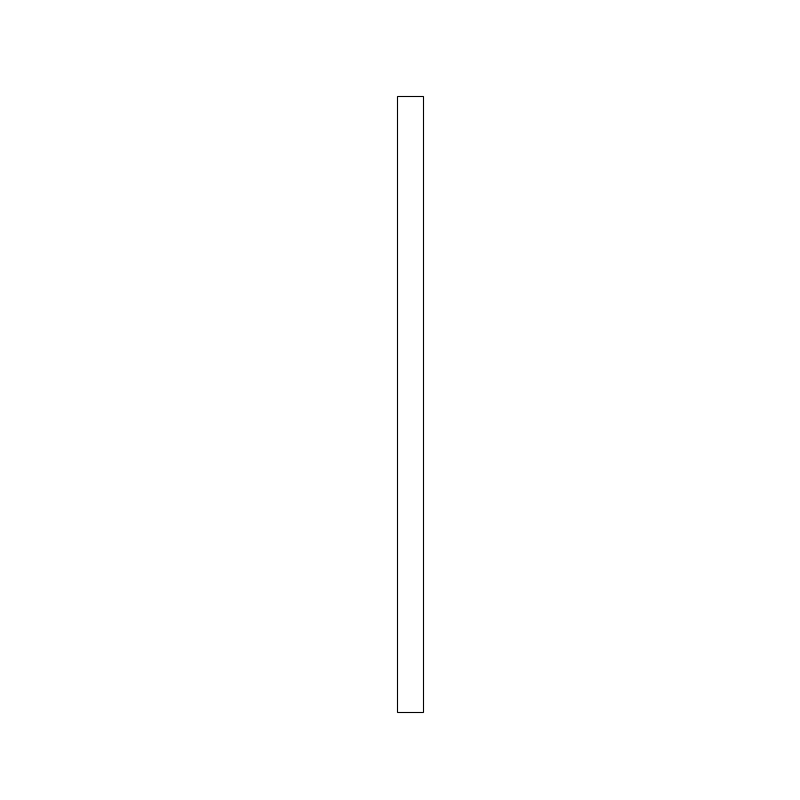

In [10]:
fig = plt.figure(figsize=(8, 8)) # create a figure 8x8 (page size in inches)
ax = plt.axes(projection=ni_utm) # create an axis object in figure using utm projection

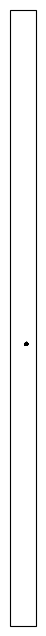

In [11]:
outline_feature = ShapelyFeature(outline['geometry'], ni_utm, edgecolor='k', facecolor='w') # add NI outline to map
ax.add_feature(outline_feature)

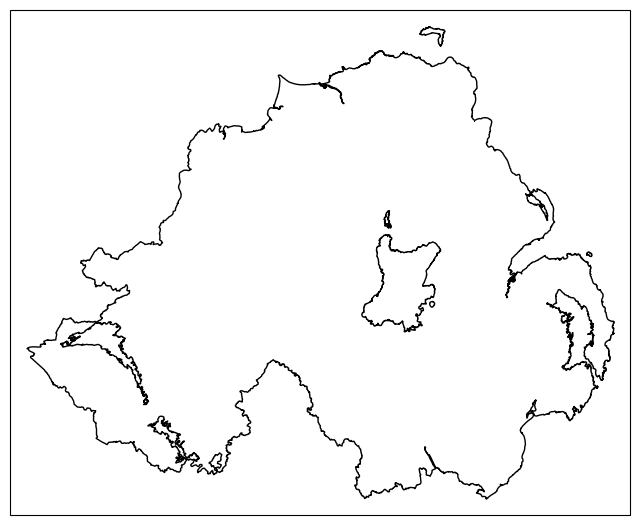

In [12]:
xmin, ymin, xmax, ymax = outline.total_bounds # using boundary of outline features, zooms map to NI
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=ni_utm) # reordered coordinates for set_extent

In [13]:
num_counties = len(counties.CountyName.unique()) # get the number of unique counties

C:\Users\byg-l\anaconda\envs\project_env\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


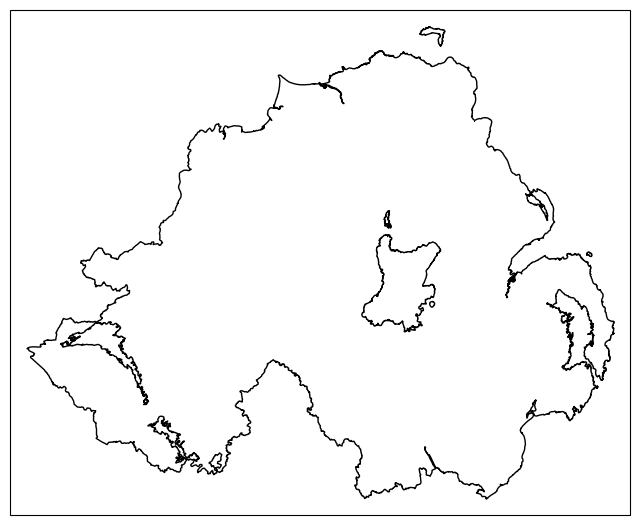

In [14]:
county_colors = ['#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600'] # pick colours for individual counties
county_names = list(counties.CountyName.unique()) # get list of individual county names
county_names.sort() # sort counties alphabetically

for ii, name in enumerate(county_names):
    feat = ShapelyFeature(counties.loc[counties['CountyName'] == name, 'geometry'], 
                          ccrs.CRS(counties.crs),
                          edgecolor='k', # outlines in black
                          facecolor=county_colors[ii], # set face colour to colour from list
                          linewidth=1,
                          alpha=0.25, # set transparencyto be 1/4
                         transform=ccrs.PlateCarree()) 
    ax.add_feature(feat)

fig

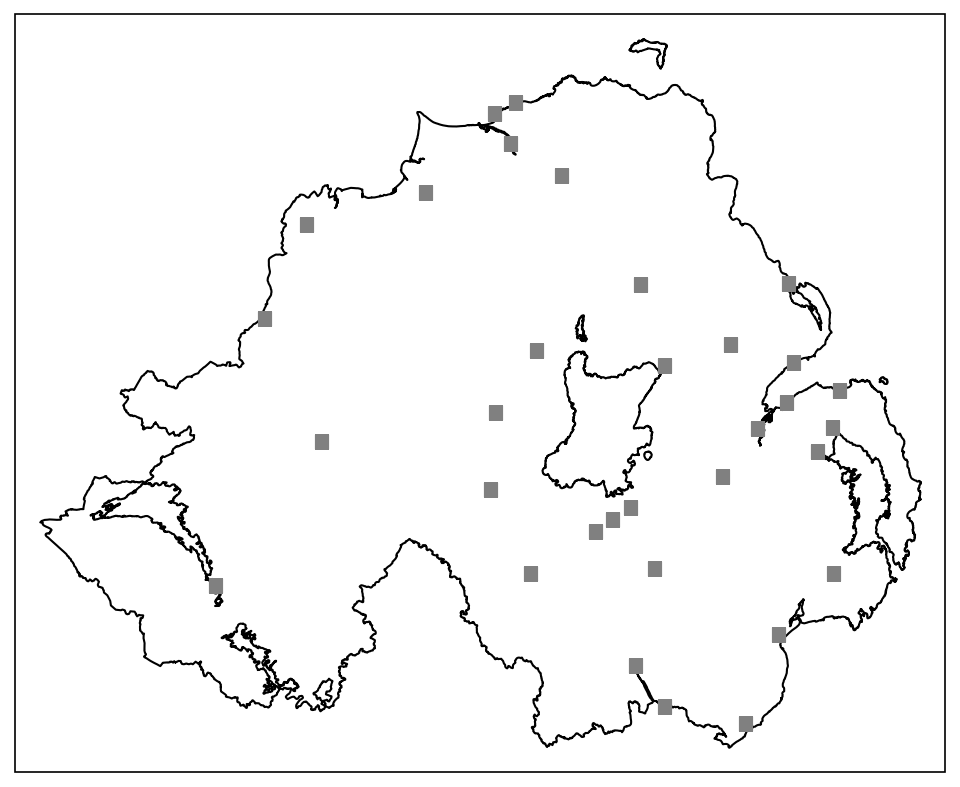

In [19]:
# add the water features with single colour symbology
water_feat = ShapelyFeature(water['geometry'],
                            ccrs.CRS(water.crs),
                            edgecolor='mediumblue',
                            facecolor='mediumblue', 
                            linewidth=1)
ax.add_feature(water_feat)
fig

In [ ]:
# add towns
town_handle = ax.plot(towns.geometry.x, towns.geometry.y, 's', color='0.5', ms=6, transform=ccrs.PlateCarree())
fig

C:\Users\byg-l\anaconda\envs\project_env\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


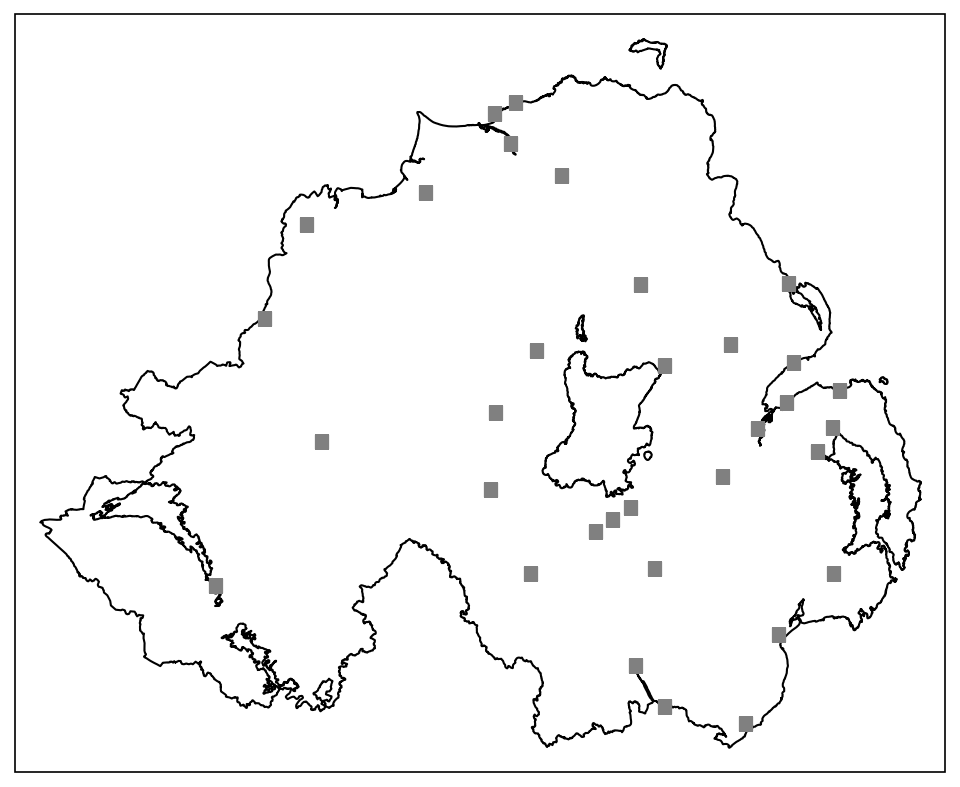

In [22]:
lepi_handle = ax.plot(lepi.geometry.x, lepi.geometry.y, 'o', color='pink', ms=6, transform=ccrs.PlateCarree())
fig